In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


train = pd.read_csv("train.csv")
campaign_data = pd.read_csv('campaign_data.csv')

In [132]:
train.shape

(1023191, 6)

Our training data consists of about one million emails sent to users.  Each email has a unique identifier, the user id of the person receiving the email, the send date, and whether they opened the email and/or clicked the link inside the email.

# Adding features

In [133]:
# adds feature to indicate the cumulative count of emails a particular user has received
train['cumulative_count'] = train.groupby('user_id').cumcount()

# add datetime column
train['date'] = pd.to_datetime(train['send_date'], format = "%d-%m-%Y %H:%M")
# set index to user_id so we can assign new columns easier
train.index = train.user_id
# drop extra columns
train.drop(['user_id','send_date'], axis = 1, inplace = True)
# create new column for number of emails
train['no_of_emails'] = train.groupby('user_id').count()['id']
train.head()


# determines whether a user has opened and clicked at least one email
# 1 for yes, 0 for no
def sorting(a):
    avg = np.mean(a)
    if avg == 0:
        return 0
    else:
        return 1

train['has_opened'] = train.groupby('user_id')['is_open'].agg(sorting)
train['has_clicked'] = train.groupby('user_id')['is_click'].agg(sorting)

# returns timestamp object day of week and hour of day
def weekday(a):
    return a.dayofweek

def hourofday(a):
    return a.hour

train['day_of_week']= train['date'].apply(weekday)
train['hour_of_day']= train['date'].apply(hourofday)
train.head()

,id,campaign_id,is_open,is_click,cumulative_count,date,no_of_emails,has_opened,has_clicked,day_of_week,hour_of_day
user_id,,,,,,,,,,,
14051,42_14051,42,0,0,0,2017-09-01 19:55:00,9,0,0,4,19
134438,52_134438,52,0,0,0,2017-11-02 12:53:00,4,0,0,3,12
181789,33_181789,33,0,0,0,2017-07-24 15:15:00,7,0,0,0,15
231448,44_231448,44,0,0,0,2017-09-05 11:36:00,6,0,0,1,11
185580,29_185580,29,0,0,0,2017-07-01 18:01:00,5,0,0,5,18


In [135]:
open_percentage = (train['is_open'].value_counts()[1] / train.shape[0]) * 100
print('Percentage of total emails that get opened: {0:.2f}%'.format(open_percentage))

Percentage of total emails that get opened: 10.05%


In [136]:
click_percentage = (train['is_click'].value_counts()[1] / train.shape[0]) * 100
print('Percentage of total emails that get clicked: {0:.2f}%'.format(click_percentage))

Percentage of total emails that get clicked: 1.25%


In [137]:
train['has_opened'].describe()

count    1.023191e+06
mean     3.802037e-01
std      4.854370e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: has_opened, dtype: float64

32.37% of people have opened at least one email.  

In [138]:
train['has_clicked'].describe()

count    1.023191e+06
mean     7.993718e-02
std      2.711960e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: has_clicked, dtype: float64

6.17% of people have clicked a link inside at least one email.

In [139]:
percentage_click_by_no_emails = train.groupby('no_of_emails')['is_click'].agg(np.mean)
percentage_click_by_no_emails

no_of_emails
1     0.007217
2     0.011204
3     0.018428
4     0.015116
5     0.012185
6     0.010641
7     0.009938
8     0.009846
9     0.011059
10    0.012526
11    0.016725
12    0.022652
13    0.032679
14    0.036742
15    0.032338
16    0.053513
17    0.047059
18    0.057692
19    0.052632
20    0.000000
Name: is_click, dtype: float64

Having received more emails correlates to a higher click rate.

In [140]:
percentage_open_by_no_emails = train.groupby('no_of_emails')['is_open'].agg(np.mean)
percentage_open_by_no_emails

no_of_emails
1     0.108314
2     0.105458
3     0.110910
4     0.104117
5     0.101311
6     0.092313
7     0.091007
8     0.091580
9     0.096695
10    0.104427
11    0.112147
12    0.133895
13    0.148064
14    0.171501
15    0.182338
16    0.225490
17    0.201070
18    0.166667
19    0.126316
20    0.150000
Name: is_open, dtype: float64

In [160]:
train.groupby('campaign_id')['day_of_week'].unique()

campaign_id
29    [5, 6]
30       [2]
31       [2]
32       [2]
33    [2, 0]
34       [1]
35       [5]
36       [3]
37       [0]
38       [5]
39       [2]
40       [4]
41       [3]
42       [4]
43       [2]
44       [1]
45       [0]
46       [3]
47       [3]
48       [0]
49       [3]
50       [4]
51       [2]
52       [3]
53       [0]
54       [4]
Name: day_of_week, dtype: object

It appears that most campaigns were all sent out on one specific day of the week (it's probably safe to assume the same exact day), except for campaign 29, which was sent out on a Saturday and Sunday and campaign 33, which occured on a Monday and Wednesday. 

In [143]:
# merge training data with campaign data
df_merge = campaign_data.merge(train, on = 'campaign_id')

# groupby to gather insights on campaigns
campaigns = df_merge.groupby('campaign_id')['is_open','is_click'].agg(np.mean)
campaigns['click_given_open'] = campaigns['is_click'] / campaigns['is_open']

campaigns['is_open'].sort_values(ascending = False)[0:5]

campaign_id
45    0.373168
39    0.352452
51    0.314529
43    0.313433
46    0.269454
Name: is_open, dtype: float64

Campaign 45 was the most successful as far as getting users to open the email. 

In [144]:
campaigns['is_click'].sort_values(ascending = False)[0:5]

campaign_id
45    0.071402
39    0.046171
35    0.043921
51    0.043792
43    0.029851
Name: is_click, dtype: float64

Campaign 45 was also the most successful at engaging users as measured by click-throughs.

In [145]:
campaigns['click_given_open'].sort_values(ascending = False)[0:5]

campaign_id
50    0.293606
52    0.292084
53    0.276105
35    0.257468
29    0.254562
Name: click_given_open, dtype: float64

At best, only about 30% of the people that open an email will end up clicking.  

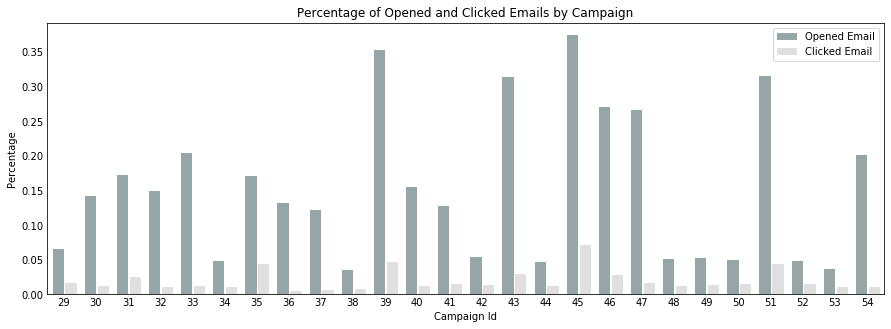

In [146]:
# Setting the positions and width for the bars
pos = list(range(len(campaigns['is_click'].values))) 
width1 = .4
width2 = .8
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(15,5))

# Create a bar with dow_open data in position pos
plt.bar(pos, list(campaigns['is_open'].values), width, alpha=0.5, color='darkslategrey') 

# Create a bar with 'dow_click' data in position pos + some width buffers
plt.bar([p + width1 for p in pos], list(campaigns['is_click'].values),width, alpha=0.5, color='silver') 

# Set the y axis label
ax.set_ylabel('Percentage')

# Set the chart's title
ax.set_title('Percentage of Opened and Clicked Emails by Campaign')

# Set the position and label of the x ticks - label is the index of the DataFrame
ax.set_xticks([p + .5 * width for p in pos])
# no emails were sent during the 21:00 hour
ax.set_xticklabels(campaigns.index)
ax.set_xlabel('Campaign Id')
ax.tick_params(axis='both', which='both', length=0)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*2)

# Adding the legend and showing the plot
plt.legend(['Opened Email', 'Clicked Email', '%'], loc = 'best')
plt.show()

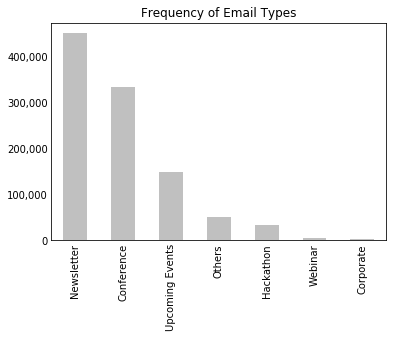

In [163]:
fig, ax = plt.subplots()
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
df_merge['communication_type'].value_counts().plot(kind = 'bar', color = 'silver')
ax.set_title('Frequency of Email Types')
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.set_major_formatter(tick) 
plt.show()

C:\Users\BradT\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


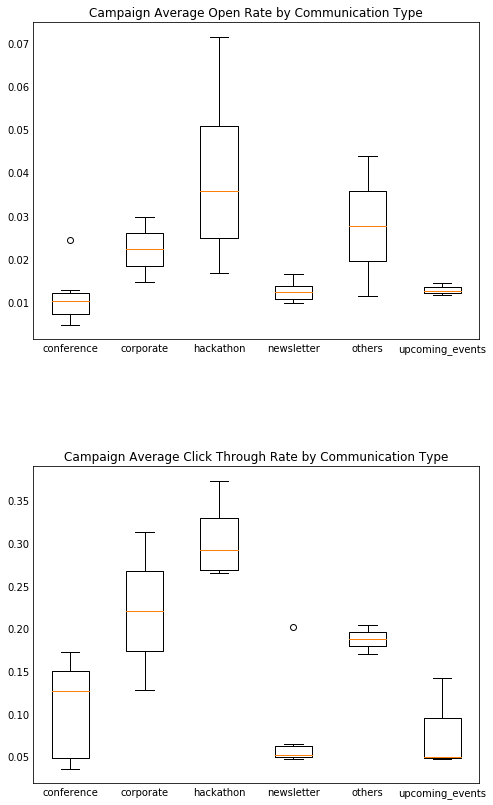

In [165]:
pivot = pd.pivot_table(df_merge, index = ['communication_type'], columns = ['campaign_id'],values = ['is_click','is_open'], fill_value = 0)
communication_types = ['conference', 'corporate', 'hackathon', 'newsletter', 'others', 'upcoming_events']
click_dict = {}
open_dict = {}
i = 0

for type in communication_types:
    
    click_dict[type] = pivot['is_click'].loc[pivot.index[i]]
    click_dict[type] = click_dict[type].loc[click_dict[type] != 0]
    
    open_dict[type] = pivot['is_open'].loc[pivot.index[i]]
    open_dict[type] = open_dict[type].loc[open_dict[type] != 0]
    
    i += 1
    
fig = plt.figure(figsize = (8,14))
ax1 = fig.add_subplot(2,1,2)
ax1.boxplot(open_dict.values())
ax1.set_xticklabels(open_dict.keys())
ax1.set_title('Campaign Average Click Through Rate by Communication Type')
ax1.tick_params(axis='both', which='both', length=0)

ax2 = fig.add_subplot(2,1,1)
ax2.boxplot(click_dict.values())
ax2.set_xticklabels(click_dict.keys())
ax2.set_title('Campaign Average Open Rate by Communication Type')
ax2.tick_params(axis='both', which='both', length=0)

fig.subplots_adjust(hspace = .4)
plt.show()

Hackathons receive the most opens and clicks, while newsletters get the least.

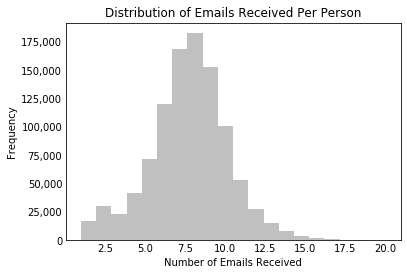

In [147]:
fig, ax = plt.subplots()
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
train['no_of_emails'].plot(kind = 'hist', bins = 20,color='silver')
ax.set_title('Distribution of Emails Received Per Person')
ax.set_xlabel('Number of Emails Received')
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.set_major_formatter(tick) 
plt.show()

The distribution of emails received is approximately normal, and slightly skewed to the right.  The mean value is about 8 emails. 

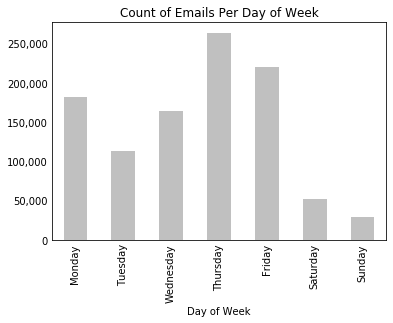

In [148]:
days = train.groupby('day_of_week').count()['id']

fig, ax = plt.subplots()
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
days.plot.bar(color='silver')
ax.set_title('Count of Emails Per Day of Week')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set_xlabel('Day of Week')
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.set_major_formatter(tick) 
plt.show()

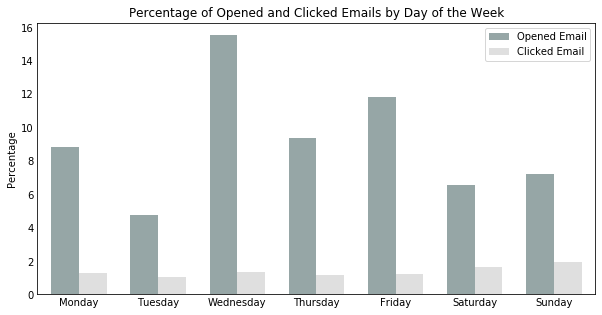

In [149]:
dow_open = train.groupby('day_of_week')['is_open'].agg(np.mean)
dow_click = train.groupby('day_of_week')['is_click'].agg(np.mean)

dow_open = dow_open.values * 100
dow_click = dow_click.values * 100

# Setting the positions and width for the bars
pos = list(range(len(dow_open))) 
width = 0.35
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with dow_open data in position pos
plt.bar(pos, list(dow_open), width, alpha=0.5, color='darkslategrey') 

# Create a bar with 'dow_click' data in position pos + some width buffers
plt.bar([p + width for p in pos],list(dow_click),width, alpha=0.5, color='silver') 

# Set the y axis label
ax.set_ylabel('Percentage')

# Set the chart's title
ax.set_title('Percentage of Opened and Clicked Emails by Day of the Week')

# Set the position and label of the x ticks - label is the index of the DataFrame
ax.set_xticks([p + .5 * width for p in pos])
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='both', which='both', length=0)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*2)

# Adding the legend and showing the plot
plt.legend(['Opened Email', 'Clicked Email'], loc = 'best')
plt.show()

Click through rates remain low througout the week, and seem to be slightly higher on the weekends.  The percentage of emails opened seems to vary greatly, with the largest percentage being on Wednesday, and the smallest on Tuesdays. 

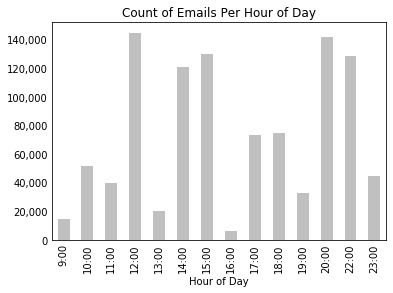

In [150]:
hours = train.groupby('hour_of_day').count()['id']

fig, ax = plt.subplots()
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
hours.plot.bar(color='silver')
ax.set_title('Count of Emails Per Hour of Day')
ax.set_xticklabels(['9:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','22:00','23:00'])
ax.set_xlabel('Hour of Day')
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.set_major_formatter(tick) 
plt.show()

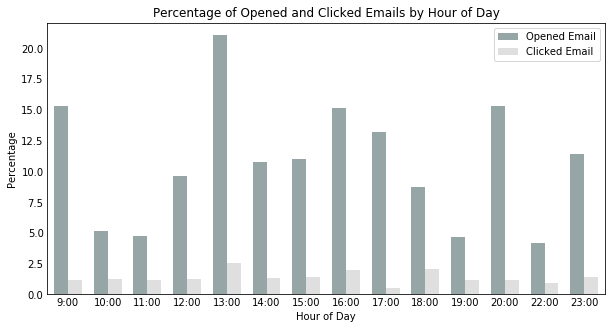

In [151]:
hod_open = train.groupby('hour_of_day')['is_open'].agg(np.mean)
hod_click = train.groupby('hour_of_day')['is_click'].agg(np.mean)

hod_open = hod_open.values * 100
hod_click = hod_click.values * 100

# Setting the positions and width for the bars
pos = list(range(len(hod_open))) 
width = 0.35
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with dow_open data in position pos
plt.bar(pos, list(hod_open), width, alpha=0.5, color='darkslategrey') 

# Create a bar with 'dow_click' data in position pos + some width buffers
plt.bar([p + width for p in pos],list(hod_click),width, alpha=0.5, color='silver') 

# Set the y axis label
ax.set_ylabel('Percentage')

# Set the chart's title
ax.set_title('Percentage of Opened and Clicked Emails by Hour of Day')

# Set the position and label of the x ticks - label is the index of the DataFrame
ax.set_xticks([p + .5 * width for p in pos])
# no emails were sent during the 21:00 hour
ax.set_xticklabels(['9:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','22:00','23:00'])
ax.set_xlabel('Hour of Day')
ax.tick_params(axis='both', which='both', length=0)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*2)

# Adding the legend and showing the plot
plt.legend(['Opened Email', 'Clicked Email'], loc = 'best')
plt.show()

Emails sent at 9:00, 13:00, 16:00, and 20:00 are the most likely to be opened.  A possible explanation is that they correspond to morning, lunch and near the end of the typical workday - although this would completely depend on the user's time zone. It does not seem to be the case that a high open percentage corresponds to a high click percentage.

## Bucket user_id WRT open and click

In [152]:
train.reset_index(inplace=True)

In [153]:
def encode_feature(df, feature_name, column_to_agg, num_buckets = 30):
    
    # create name for new feture, and copy the dataframe
    bucket = feature_name + '_bucket_interval'
    bucket_val = feature_name + '_' + column_to_agg + '_bucket_avg_val'
    df_copy = df.copy()
        
    # create a new feature that contains the interval to which the observation belongs
    df_copy[bucket] = pd.qcut(df[feature_name],num_buckets, duplicates = 'drop') 
        
    # group the intervals together and calculate the mean price for each interval/bucket
    df_new = df_copy.groupby(df_copy[bucket], as_index = False).agg({column_to_agg:'mean'})
    df_new = pd.DataFrame(df_new)
    
    # specify the column names, and create a row that contains the number of the bucket for plotting
    df_new.rename(columns = {column_to_agg:bucket_val}, inplace = True)
    df_new['bucket_number'] = df_new.index + 1
    df_new.head()
    
    # show a scatter plot of the buckets
    fig, ax = plt.subplots(figsize = (8,6))
    plt.scatter(df_new.bucket_number,df_new[bucket_val])
    plt.xlabel('Bucket Number - ' + feature_name)
    plt.ylabel('Average Bucket Value - ' + column_to_agg)
    #ax.yaxis.set_major_formatter(tick) 
    plt.show()
    
    #join df and df_new on the new bucket_interval feature
    df_join = pd.merge(df_new, df_copy, on=bucket)
    df_join.drop([bucket, 'bucket_number'], axis = 1, inplace = True)
    return df_join

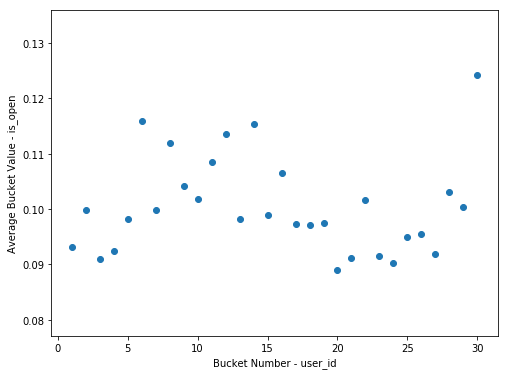

In [154]:
train = encode_feature(train, 'user_id', 'is_open')

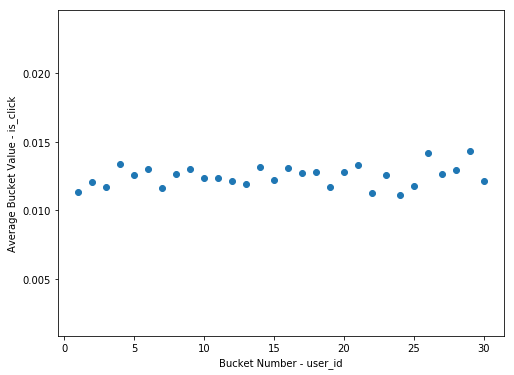

In [155]:
train = encode_feature(train, 'user_id', 'is_click')

The click through rate is fairly constant, fluctuating between .011 and .015 for each grouping of users.  There seems to be a very slight positive slope, which may indicate that newer users are clicking at a higher frequency, or perhaps that as users gain familiarity with the types of emails they receive, they become less inclined to click on links. 

Having received more emails correlates to a higher open rate.

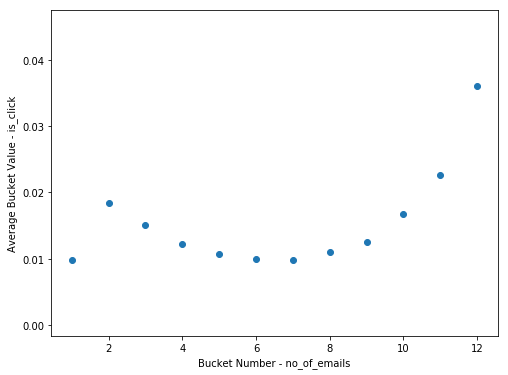

In [157]:
train = encode_feature(train, 'no_of_emails', 'is_click')

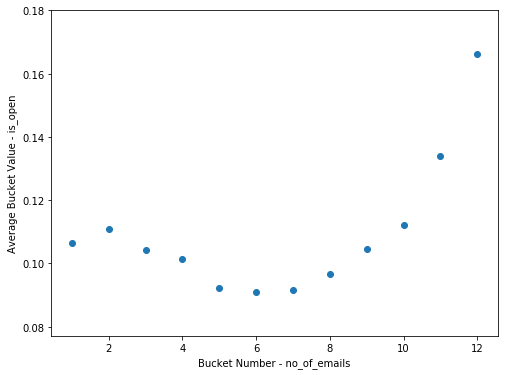

In [158]:
train = encode_feature(train,'no_of_emails', 'is_open')

In [167]:
df_merge = campaign_data.merge(train, on = 'campaign_id')
df_merge.head(10)

,campaign_id,communication_type,total_links,no_of_internal_links,no_of_images,no_of_sections,email_body,subject,email_url,no_of_emails_is_open_bucket_avg_val,no_of_emails_is_click_bucket_avg_val,user_id_is_click_bucket_avg_val,user_id_is_open_bucket_avg_val,user_id,id,is_open,is_click,cumulative_count,date,no_of_emails,has_opened,has_clicked,day_of_week,hour_of_day
0,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.011316,0.093078,4378,29_4378,0,0,1,2017-07-01 18:06:00,2,0,0,5,18
1,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.011316,0.093078,1070,29_1070,1,0,0,2017-07-01 18:14:00,1,1,0,5,18
2,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.011316,0.093078,4082,29_4082,0,0,0,2017-07-02 18:01:00,1,0,0,6,18
3,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.011316,0.093078,383,29_383,0,0,1,2017-07-01 18:04:00,2,0,0,5,18
4,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.011316,0.093078,8163,29_8163,0,0,1,2017-07-02 18:02:00,2,0,0,6,18
5,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.011316,0.093078,4006,29_4006,0,0,0,2017-07-01 18:15:00,1,0,0,5,18
6,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.011316,0.093078,791,29_791,0,0,1,2017-07-02 18:00:00,2,0,0,6,18
7,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.011316,0.093078,3814,29_3814,0,0,0,2017-07-01 18:04:00,2,1,0,5,18
8,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.012050,0.099892,11371,29_11371,0,0,0,2017-07-02 18:02:00,1,0,0,6,18
9,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...,0.106471,0.009791,0.012050,0.099892,13551,29_13551,1,0,0,2017-07-01 18:11:00,1,1,0,5,18
